# How are Chicagoans using E-Scooters?

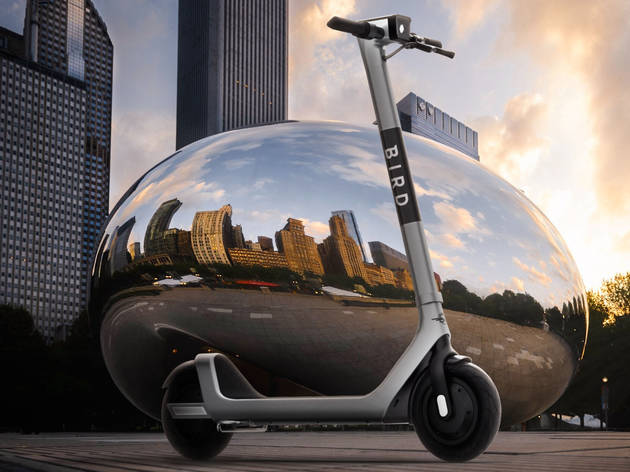

In 2019 and 2020, Chicago introduced two E-Scooter pilot programs resulting in the scooter's permanant prescence in 2021.  

This particular analysis will look at overall E-Scooter trip patterns in Chicago in 2022, 1 year after it's implementation, using publicicly available E-Scooter data at https://data.cityofchicago.org/.


# Datasets

2 datasets were used:

<b>E-Scooter Trips</b> - A .csv file containing all 2022 rides. Each row represents a unique trip. Data retrievel began in mid-May 2022. This dataset is used as the primary datset for this study.<br>

<b>Trip ID</b> - A unique ID for each trip.<br>
<b>Start Time</b> - When the trip started, rounded to the nearest hour.<br>
<b>End Time</b> - When the trip ended, rounded to the nearest hour.<br>
<b>Trip Distance</b> - Trip distance in meters. (Divide by 1609 for miles.)<br>
<b>Trip Duration</b> - Trip time in seconds.<br>
<b>Vendor</b> - The vendor of the scooter<br>
<b>Start Community Area Number</b> - The Community Area number where the trip started.<br>
<b>End Community Area Number</b> - The Community Area number where the trip ended.<br>
<b>Start Community Area Name</b> - The Community Area name where the trip started.<br>
<b>End Community Area Name</b> - The Community Area name where the trip ended.<br>
<b>Start Centroid Latitude</b> - The latitude of the center of the trip start Community Area. This column will be blank for locations outside Chicago.<br>
<b>Start Centroid Longitude</b> - The longitude of the center of the trip start Community Area. This column will be blank for locations outside Chicago.<br>
<b>Start Centroid Location</b>- The location of the center of the trip start Community Area. This column will be blank for locations outside Chicago.<br>
<b>End Centroid Latitude</b> - The latitude of the center of the trip end Community Area. This column will be blank for locations outside Chicago.<br>
<b>End Centroid Longitude</b> - The longitude of the center of the trip end Community Area. This column will be blank for locations outside Chicago.<br>
<b>End Centroid Location</b> - The location of the center of the trip end Community Area. This column will be blank for locations outside Chicago.

<b> Boundaries - Community Area </b> - A shape file with geographic location data to be used to create choropleth maps.


These datasets were ultimately joined by Start Community Area Name/Community Area name after some clean-up to create one merged dataset.

# Data Clean-up and Pre-Processing

In [1]:
#Importing relevant libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import geopandas

In [7]:
#Importing scooter csv file
es_data = pd.read_csv("/kaggle/input/e-scooter-trips-csv/E-Scooter_Trips.csv")

In [8]:
#Printing number of rows and columns in primary dataset
print("There are " + str(es_data.shape[0]) + " columns and " + str(es_data.shape[1]) + " rows in this dataset.")

There are 1491790 columns and 16 rows in this dataset.


For reference, Chicago reported a population of 2,746,352 in 2022.

In [9]:
#Looking at unique number of values in each column
es_data.nunique()

Trip ID                        1491790
Start Time                        4736
End Time                          5016
Trip Distance                    22032
Trip Duration                     9883
Vendor                               4
Start Community Area Number         77
End Community Area Number           77
Start Community Area Name           77
End Community Area Name             77
Start Centroid Latitude             77
Start Centroid Longitude            77
Start Centroid Location             77
End Centroid Latitude               77
End Centroid Longitude              77
End Centroid Location               77
dtype: int64

In [10]:
#Inspecting first 5 rows of data
es_data.head()

,Trip ID,Start Time,End Time,Trip Distance,Trip Duration,Vendor,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location
0,17553846-c8d6-b9de-1755-3846c8d6b9de,05/28/2022 02:00:00 PM,05/28/2022 03:00:00 PM,2484,1544,Lyft,32.0,32.0,Loop,Loop,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445)
1,1756d4dc-ccf1-af42-1756-d4dcccf1af42,05/29/2022 07:00:00 PM,05/29/2022 08:00:00 PM,36,135,Lyft,32.0,32.0,Loop,Loop,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445)
2,1756d578-f376-9950-1756-d578f3769950,05/29/2022 08:00:00 PM,05/29/2022 08:00:00 PM,2653,1972,Lyft,32.0,NaN,Loop,NaN,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),NaN,NaN,NaN
3,1756fc61-f058-c200-1756-fc61f058c200,05/29/2022 10:00:00 PM,05/29/2022 10:00:00 PM,105,137,Lyft,32.0,NaN,Loop,NaN,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),NaN,NaN,NaN
4,17659074-0cfd-92ca-1765-90740cfd92ca,06/10/2022 12:00:00 AM,06/10/2022 12:00:00 AM,2299,540,Lyft,8.0,24.0,Near North Side,West Town,41.899602,-87.633309,POINT (-87.63330943703569 41.899602106426094),41.901207,-87.676357,POINT (-87.67635712603905 41.90120673431551)


In [11]:
#Converting date columns to datetime format
es_data["Start Time"] = pd.to_datetime(es_data["Start Time"], format="%m/%d/%Y %I:%M:%S %p")
es_data["End Time"] = pd.to_datetime(es_data["End Time"], format="%m/%d/%Y %I:%M:%S %p")

In [12]:
#Renaming Trip Duration to Trip Duration Seconds
es_data = es_data.rename(columns = {"Trip Duration": "Trip Duration Seconds"})

#Renaming Trip Distance to Trip Distance Meters
es_data= es_data.rename(columns = {"Trip Distance": "Trip Distance Meters" })

In [13]:
#Creating new column based on Trip Duration Seconds to Trip Duration Minutes.
es_data["Trip Duration Minutes"] = round(es_data["Trip Duration Seconds"]/60, 2)

#Creating new column based on Trip Distance Meters to Trip Distance Miles.
es_data["Trip Distance Miles"] = round(es_data["Trip Distance Meters"]/1609, 2)

In [14]:
#Looking at updated datatypes of each column
es_data.dtypes

Trip ID                                object
Start Time                     datetime64[ns]
End Time                       datetime64[ns]
Trip Distance Meters                    int64
Trip Duration Seconds                   int64
Vendor                                 object
Start Community Area Number           float64
End Community Area Number             float64
Start Community Area Name              object
End Community Area Name                object
Start Centroid Latitude               float64
Start Centroid Longitude              float64
Start Centroid Location                object
End Centroid Latitude                 float64
End Centroid Longitude                float64
End Centroid Location                  object
Trip Duration Minutes                 float64
Trip Distance Miles                   float64
dtype: object

In [15]:
#Extracing Year, Month, and Hour from Start Time columns
es_data["Year"] = es_data["Start Time"].dt.year
es_data["Month"] = es_data["Start Time"].dt.month
es_data["Hour"] = es_data["Start Time"].dt.hour

In [16]:
#Investigating null/missing values
es_data.isna().sum()

Trip ID                           0
Start Time                        0
End Time                          0
Trip Distance Meters              0
Trip Duration Seconds             0
Vendor                            0
Start Community Area Number     959
End Community Area Number      1434
Start Community Area Name       959
End Community Area Name        1434
Start Centroid Latitude         959
Start Centroid Longitude        959
Start Centroid Location         959
End Centroid Latitude          1434
End Centroid Longitude         1434
End Centroid Location          1434
Trip Duration Minutes             0
Trip Distance Miles               0
Year                              0
Month                             0
Hour                              0
dtype: int64

In [17]:
#Examining trips where "Trip Distance Meters" = 0.
es_data[es_data["Trip Distance Meters"]<= 0].shape[0]

13336

In [18]:
es_data[es_data["Trip Distance Meters"]<= 0].describe()

,Start Time,End Time,Trip Distance Meters,Trip Duration Seconds,Start Community Area Number,End Community Area Number,Start Centroid Latitude,Start Centroid Longitude,End Centroid Latitude,End Centroid Longitude,Trip Duration Minutes,Trip Distance Miles,Year,Month,Hour
count,13336,13336,13336.0,13336.000000,13335.000000,13335.000000,13335.000000,13335.000000,13335.000000,13335.000000,13336.000000,13336.0,13336.0,13336.000000,13336.000000
mean,2022-09-04 15:32:16.592681728,2022-09-04 15:35:58.218356480,0.0,227.135198,31.028496,31.028496,41.870779,-87.676309,41.870779,-87.676309,3.785574,0.0,2022.0,8.642322,15.784493
min,2022-05-14 19:00:00,2022-05-14 19:00:00,0.0,0.000000,1.000000,1.000000,41.660137,-87.893701,41.660137,-87.893701,0.000000,0.0,2022.0,5.000000,0.000000
25%,2022-08-03 08:00:00,2022-08-03 08:00:00,0.0,35.000000,14.000000,14.000000,41.796186,-87.711211,41.796186,-87.711211,0.580000,0.0,2022.0,8.000000,13.000000
50%,2022-09-04 11:00:00,2022-09-04 11:00:00,0.0,40.000000,24.000000,24.000000,41.900070,-87.676357,41.900070,-87.676357,0.670000,0.0,2022.0,9.000000,16.000000
75%,2022-10-05 12:00:00,2022-10-05 12:00:00,0.0,59.000000,49.000000,49.000000,41.924348,-87.649490,41.924348,-87.649490,0.980000,0.0,2022.0,10.000000,19.000000
max,2022-12-30 14:00:00,2022-12-30 14:00:00,0.0,14488.000000,77.000000,77.000000,42.009623,-87.534902,42.009623,-87.534902,241.470000,0.0,2022.0,12.000000,23.000000
std,NaN,NaN,0.0,765.878543,21.814116,21.814116,0.082187,0.048154,0.082187,0.048154,12.764667,0.0,0.0,1.410068,4.921907


In [19]:
#Examining trips where "Trip Duration Seconds" = 0
es_data[es_data["Trip Duration Seconds"]<= 0].shape[0]

167

In [20]:
es_data[es_data["Trip Duration Seconds"]<= 0]

,Trip ID,Start Time,End Time,Trip Distance Meters,Trip Duration Seconds,Vendor,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,...,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location,Trip Duration Minutes,Trip Distance Miles,Year,Month,Hour
1158,1742d052-a6bb-81f6-1742-d052a6bb81f6,2022-05-14 15:00:00,2022-05-14 15:00:00,5,0,Lyft,28.0,28.0,Near West Side,Near West Side,...,-87.663518,POINT (-87.66351788670023 41.8740053848845),41.874005,-87.663518,POINT (-87.66351788670023 41.8740053848845),0.00,0.00,2022,5,15
37246,175575da-c654-a7b2-1755-75dac654a7b2,2022-05-28 19:00:00,2022-05-28 19:00:00,24,-2,Lyft,7.0,7.0,Lincoln Park,Lincoln Park,...,-87.649490,POINT (-87.64948972103548 41.922686117884986),41.922686,-87.649490,POINT (-87.64948972103548 41.922686117884986),-0.03,0.01,2022,5,19
51612,1758df5a-bd23-fa86-1758-df5abd23fa86,2022-05-31 09:00:00,2022-05-31 09:00:00,16,-3,Lyft,7.0,7.0,Lincoln Park,Lincoln Park,...,-87.649490,POINT (-87.64948972103548 41.922686117884986),41.922686,-87.649490,POINT (-87.64948972103548 41.922686117884986),-0.05,0.01,2022,5,9
57186,1762a317-4786-85ac-1762-a317478685ac,2022-06-07 17:00:00,2022-06-07 17:00:00,28,-592,Lyft,32.0,32.0,Loop,Loop,...,-87.625192,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),-9.87,0.02,2022,6,17
57548,17629d75-39da-c774-1762-9d7539dac774,2022-06-07 17:00:00,2022-06-07 17:00:00,11768,0,Lyft,8.0,8.0,Near North Side,Near North Side,...,-87.633309,POINT (-87.63330943703569 41.899602106426094),41.899602,-87.633309,POINT (-87.63330943703569 41.899602106426094),0.00,7.31,2022,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392558,4b4f9b65-3c35-450b-b4c1-afacca9a6a9b,2022-11-16 14:00:00,2022-11-16 14:00:00,10,0,Lime,6.0,6.0,Lake View,Lake View,...,-87.655999,POINT (-87.65599892982179 41.944226870503684),41.944227,-87.655999,POINT (-87.65599892982179 41.944226870503684),0.00,0.01,2022,11,14
1393273,1834519c-3b44-44dc-1834-519c3b4444dc,2022-11-13 19:00:00,2022-11-13 19:00:00,7,0,Lyft,28.0,28.0,Near West Side,Near West Side,...,-87.663518,POINT (-87.66351788670023 41.8740053848845),41.874005,-87.663518,POINT (-87.66351788670023 41.8740053848845),0.00,0.00,2022,11,19
1394440,3cbedbfe-6a35-4310-be2a-5ba9fc053c57,2022-11-13 16:00:00,2022-11-13 16:00:00,0,0,Lime,19.0,19.0,Belmont Cragin,Belmont Cragin,...,-87.765502,POINT (-87.76550183689795 41.927260741518765),41.927261,-87.765502,POINT (-87.76550183689795 41.927260741518765),0.00,0.00,2022,11,16
1459241,3aea8015-692c-4921-bfcb-5b191b8a946c,2022-12-02 16:00:00,2022-12-02 16:00:00,18,0,Lime,77.0,3.0,Edgewater,Uptown,...,-87.663417,POINT (-87.66341660678424 41.98671222550283),41.965812,-87.655879,POINT (-87.65587931915152 41.965812077713245),0.00,0.01,2022,12,16


In [21]:
es_data[es_data["Trip Duration Seconds"]<= 0].describe()

,Start Time,End Time,Trip Distance Meters,Trip Duration Seconds,Start Community Area Number,End Community Area Number,Start Centroid Latitude,Start Centroid Longitude,End Centroid Latitude,End Centroid Longitude,Trip Duration Minutes,Trip Distance Miles,Year,Month,Hour
count,167,167,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.0,167.000000,167.000000
mean,2022-07-22 09:21:11.856287232,2022-07-22 09:20:50.299401216,16792.041916,-113.107784,27.461078,27.143713,41.869438,-87.658241,41.869012,-87.658412,-1.884970,10.435569,2022.0,7.293413,16.395210
min,2022-05-14 15:00:00,2022-05-14 15:00:00,0.000000,-2896.000000,3.000000,3.000000,41.660535,-87.803450,41.660535,-87.803450,-48.270000,0.000000,2022.0,5.000000,7.000000
25%,2022-06-07 17:00:00,2022-06-07 17:00:00,2.000000,-121.500000,8.000000,8.000000,41.860190,-87.676357,41.860190,-87.676357,-2.025000,0.000000,2022.0,6.000000,16.000000
50%,2022-07-07 18:00:00,2022-07-07 18:00:00,10.000000,0.000000,28.000000,28.000000,41.899602,-87.655999,41.899602,-87.655879,0.000000,0.010000,2022.0,7.000000,17.000000
75%,2022-08-27 13:30:00,2022-08-27 13:30:00,4929.000000,0.000000,32.000000,32.000000,41.911946,-87.633309,41.911946,-87.633309,0.000000,3.065000,2022.0,8.000000,17.000000
max,2022-12-15 17:00:00,2022-12-15 17:00:00,539397.000000,0.000000,77.000000,77.000000,41.986712,-87.546575,41.986712,-87.546575,0.000000,335.240000,2022.0,12.000000,23.000000
std,NaN,NaN,58052.427443,280.608354,19.841768,19.485019,0.072071,0.042141,0.071697,0.042231,4.677085,36.080152,0.0,1.576604,2.789736


There are 13,336 trips with a recorded 0 for Trip Distance Meters, even though Start Time, End Time, Start Area and End Area are available. We will drop these rows as these trips might have been people checking-in/checking-out scooters with either no real intention of using them or later changed their mind.
In regards to trips with a recorded 0 or less for Trip Duration Seconds, there are 167 trips. Again, we will drop these rows as these trips did not last a full second.

In [22]:
#Creating a new dataframe excluding "joy rides."
es_data_new = es_data.loc[(es_data["Trip Distance Meters"] > 0) & (es_data["Trip Duration Seconds"] > 0), :]


In [23]:
#Printing new number of rows in our dataset 
es_data_new.shape[0]

1478310

Now, let's look at missing Community Area names for both Start and End columns.

In [24]:
#Displaying number of rows with no End Community Area Name
es_data_new[es_data_new["End Community Area Name"].isna()].shape[0]

1433

In [25]:
#Displaying rows with no End Community Area Name
es_data_new[es_data_new["End Community Area Name"].isna()]

,Trip ID,Start Time,End Time,Trip Distance Meters,Trip Duration Seconds,Vendor,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,...,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location,Trip Duration Minutes,Trip Distance Miles,Year,Month,Hour
2,1756d578-f376-9950-1756-d578f3769950,2022-05-29 20:00:00,2022-05-29 20:00:00,2653,1972,Lyft,32.0,NaN,Loop,NaN,...,-87.625192,POINT (-87.62519186960115 41.87886594636445),NaN,NaN,NaN,32.87,1.65,2022,5,20
3,1756fc61-f058-c200-1756-fc61f058c200,2022-05-29 22:00:00,2022-05-29 22:00:00,105,137,Lyft,32.0,NaN,Loop,NaN,...,-87.625192,POINT (-87.62519186960115 41.87886594636445),NaN,NaN,NaN,2.28,0.07,2022,5,22
5,5e0448df-4f8d-4a96-944b-3d81a5892a97,2022-06-16 21:00:00,2022-06-16 21:00:00,1606,948,Spin,25.0,NaN,Austin,NaN,...,-87.763112,POINT (-87.76311182422577 41.89410129611355),NaN,NaN,NaN,15.80,1.00,2022,6,21
6,6702c481-50d8-49ed-b13a-3e3b8ccced37,2022-06-17 16:00:00,2022-06-17 17:00:00,3065,1577,Lime,7.0,NaN,Lincoln Park,NaN,...,-87.649490,POINT (-87.64948972103548 41.922686117884986),NaN,NaN,NaN,26.28,1.90,2022,6,16
7,112d6f15-89fd-4b03-b30a-5e3348c590ba,2022-06-18 23:00:00,2022-06-19 01:00:00,2498,5563,Lime,25.0,NaN,Austin,NaN,...,-87.763112,POINT (-87.76311182422577 41.89410129611355),NaN,NaN,NaN,92.72,1.55,2022,6,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1442095,6de78385-d529-409e-b7b8-d391787b096c,2022-11-24 11:00:00,2022-11-24 11:00:00,4909,979,Lime,73.0,NaN,Washington Heights,NaN,...,-87.648895,POINT (-87.64889548780168 41.717493882926085),NaN,NaN,NaN,16.32,3.05,2022,11,11
1443136,92fc283d-72e8-4c7a-9322-98b6c3a1563d,2022-11-25 15:00:00,2022-11-25 17:00:00,11543,6161,Spin,25.0,NaN,Austin,NaN,...,-87.763112,POINT (-87.76311182422577 41.89410129611355),NaN,NaN,NaN,102.68,7.17,2022,11,15
1443347,1c35b4dc-01a6-4e9d-b5a8-7a887a7939f2,2022-11-28 14:00:00,2022-11-28 14:00:00,3151,1802,Lime,65.0,NaN,West Lawn,NaN,...,-87.726929,POINT (-87.72692933445072 41.769779031541276),NaN,NaN,NaN,30.03,1.96,2022,11,14
1464537,7e70a041-f235-4f4b-b647-69b0dfea7c37,2022-12-07 17:00:00,2022-12-07 17:00:00,1298,2353,Lime,25.0,NaN,Austin,NaN,...,-87.763112,POINT (-87.76311182422577 41.89410129611355),NaN,NaN,NaN,39.22,0.81,2022,12,17


It looks like it is possible to have a missing End Community Area Name, but have a present Start Community Area Name. Let's look if this is the case vice versa.

In [26]:
#Displaying number of rows with no Start Community Area Name
es_data_new[es_data_new["Start Community Area Name"].isna()].shape[0]

958

In [27]:
#Displaying rows with no Start Community Area Name
es_data_new[es_data_new["Start Community Area Name"].isna()]

,Trip ID,Start Time,End Time,Trip Distance Meters,Trip Duration Seconds,Vendor,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,...,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location,Trip Duration Minutes,Trip Distance Miles,Year,Month,Hour
9,68d142a7-4402-4c7a-b0c6-1d5929b0f92b,2022-06-20 15:00:00,2022-06-20 15:00:00,11094,2670,Lime,NaN,19.0,NaN,Belmont Cragin,...,NaN,NaN,41.927261,-87.765502,POINT (-87.76550183689795 41.927260741518765),44.50,6.89,2022,6,15
12,087b1383-a12e-4423-bf9b-8385aafea91d,2022-06-21 12:00:00,2022-06-21 13:00:00,1840,200,Lime,NaN,72.0,NaN,Beverly,...,NaN,NaN,41.713150,-87.675075,POINT (-87.67507504919699 41.71314972583587),3.33,1.14,2022,6,12
13,10e71a3f-9d1c-419e-b00b-ec8ef6f71542,2022-06-21 19:00:00,2022-06-21 20:00:00,1299,1049,Lime,NaN,17.0,NaN,Dunning,...,NaN,NaN,41.946511,-87.806020,POINT (-87.80601984481356 41.94651066317405),17.48,0.81,2022,6,19
14,762eb628-6f8b-4290-be76-5b94e1f1d4e1,2022-06-21 23:00:00,2022-06-21 23:00:00,138,1275,Lime,NaN,7.0,NaN,Lincoln Park,...,NaN,NaN,41.922686,-87.649490,POINT (-87.64948972103548 41.922686117884986),21.25,0.09,2022,6,23
18,34886f98-a88b-42d2-b82d-87994a9eba6b,2022-06-22 14:00:00,2022-06-22 15:00:00,1637,1721,Lime,NaN,18.0,NaN,Montclare,...,NaN,NaN,41.929298,-87.798032,POINT (-87.79803232487092 41.92929769096121),28.68,1.02,2022,6,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1442358,1ade1786-0ab9-4f2b-b897-043922d5d0b0,2022-11-29 15:00:00,2022-11-29 16:00:00,9729,5586,Lime,NaN,25.0,NaN,Austin,...,NaN,NaN,41.894101,-87.763112,POINT (-87.76311182422577 41.89410129611355),93.10,6.05,2022,11,15
1443585,0e144f48-a873-463f-b760-6a8471a8f53f,2022-11-28 19:00:00,2022-11-28 19:00:00,1519,617,Lime,NaN,25.0,NaN,Austin,...,NaN,NaN,41.894101,-87.763112,POINT (-87.76311182422577 41.89410129611355),10.28,0.94,2022,11,19
1444637,6fc36b41-a7c0-427e-b59d-7e938732660e,2022-11-26 17:00:00,2022-11-26 18:00:00,6716,873,Lime,NaN,52.0,NaN,East Side,...,NaN,NaN,41.707314,-87.534902,POINT (-87.5349023379022 41.70731396174524),14.55,4.17,2022,11,17
1464440,3ab28bcb-ff3e-4809-b797-1286ba271a80,2022-12-02 21:00:00,2022-12-02 21:00:00,1331,481,Lime,NaN,12.0,NaN,Forest Glen,...,NaN,NaN,41.993931,-87.758356,POINT (-87.75835628921875 41.99393065407914),8.02,0.83,2022,12,21


Looks like the same applies. We will drop these rows as these trips may not be reliable due to the missing Start and End areas.

In [28]:
#Let's fill in missing values with 'Not Available' first.
es_data_new[["End Community Area Name","Start Community Area Name"]] = es_data_new[["End Community Area Name","Start Community Area Name"]].fillna("Not Available")

/tmp/ipykernel_32/2909883248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_data_new[["End Community Area Name","Start Community Area Name"]] = es_data_new[["End Community Area Name","Start Community Area Name"]].fillna("Not Available")


In [29]:
#Creating new dataframe with only available Community Area Names
es_data_new = es_data_new[(es_data_new["Start Community Area Name"] != "Not Available") & (es_data_new["End Community Area Name"] != "Not Available")]

Let's explore the dates a little closer.

In [30]:
#Finding minimum date value.
es_data_new["Start Time"].min()

Timestamp('2022-05-10 09:00:00')

The earliest date we have is 5/10/2022, which means we are missing the first 9 days of May's data.

In [31]:
#Finding maximum date value.
es_data_new["End Time"].max()

Timestamp('2023-01-01 00:00:00')

In [32]:
#Finding number of entries with 2023 data
es_data_new[es_data_new["Year"] == 2023].shape[0]

19

In [33]:
es_data_new[es_data_new["Year"] == 2023].describe()

,Start Time,End Time,Trip Distance Meters,Trip Duration Seconds,Start Community Area Number,End Community Area Number,Start Centroid Latitude,Start Centroid Longitude,End Centroid Latitude,End Centroid Longitude,Trip Duration Minutes,Trip Distance Miles,Year,Month,Hour
count,19,19,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0,19.0
mean,2023-01-01 00:00:00,2023-01-01 00:00:00,1333.052632,614.000000,17.578947,15.894737,41.890818,-87.646001,41.894024,-87.638786,10.232632,0.827895,2023.0,1.0,0.0
min,2023-01-01 00:00:00,2023-01-01 00:00:00,25.000000,64.000000,7.000000,7.000000,41.850266,-87.676357,41.850266,-87.676357,1.070000,0.020000,2023.0,1.0,0.0
25%,2023-01-01 00:00:00,2023-01-01 00:00:00,513.500000,249.000000,8.000000,8.000000,41.876436,-87.663518,41.889234,-87.633309,4.150000,0.320000,2023.0,1.0,0.0
50%,2023-01-01 00:00:00,2023-01-01 00:00:00,1133.000000,528.000000,8.000000,8.000000,41.899602,-87.633309,41.899602,-87.633309,8.800000,0.700000,2023.0,1.0,0.0
75%,2023-01-01 00:00:00,2023-01-01 00:00:00,1953.000000,837.000000,28.000000,27.500000,41.899602,-87.633309,41.899602,-87.633309,13.950000,1.215000,2023.0,1.0,0.0
max,2023-01-01 00:00:00,2023-01-01 00:00:00,3798.000000,1533.000000,32.000000,32.000000,41.922686,-87.625192,41.922686,-87.625192,25.550000,2.360000,2023.0,1.0,0.0
std,NaN,NaN,1074.357300,444.444347,10.673518,10.958988,0.016644,0.018048,0.015094,0.016390,7.406921,0.667454,0.0,0.0,0.0


Since we are only interested in 2022 trips, let's drop the 19 trips on 1/1/2023.

In [34]:
#Creating new dataframe only containing 2022 data
es_data_clean = es_data_new[es_data_new["Year"] == 2022]

In [35]:
pd.options.mode.chained_assignment = None  # default='warn'

In [36]:
#Adding Weekday column extracted from Start Time column.
es_data_clean['Weekday'] = es_data_clean['Start Time'].dt.isocalendar().day

In [37]:
#Converting Weekday into int32.
es_data_clean["Weekday"] = es_data_clean["Weekday"].astype(int)

In [38]:
#Converting columns into str
es_data_clean[["Vendor", "Start Community Area Name", "End Community Area Name"]] = es_data_clean[["Vendor", "Start Community Area Name", "End Community Area Name"]].astype("str")

In [39]:
#Setting Trip ID as index
es_data_clean.set_index("Trip ID")

,Start Time,End Time,Trip Distance Meters,Trip Duration Seconds,Vendor,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,Start Centroid Latitude,...,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location,Trip Duration Minutes,Trip Distance Miles,Year,Month,Hour,Weekday
Trip ID,,,,,,,,,,,,,,,,,,,,,
17553846-c8d6-b9de-1755-3846c8d6b9de,2022-05-28 14:00:00,2022-05-28 15:00:00,2484,1544,Lyft,32.0,32.0,Loop,Loop,41.878866,...,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),25.73,1.54,2022,5,14,6
1756d4dc-ccf1-af42-1756-d4dcccf1af42,2022-05-29 19:00:00,2022-05-29 20:00:00,36,135,Lyft,32.0,32.0,Loop,Loop,41.878866,...,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),2.25,0.02,2022,5,19,7
17659074-0cfd-92ca-1765-90740cfd92ca,2022-06-10 00:00:00,2022-06-10 00:00:00,2299,540,Lyft,8.0,24.0,Near North Side,West Town,41.899602,...,POINT (-87.63330943703569 41.899602106426094),41.901207,-87.676357,POINT (-87.67635712603905 41.90120673431551),9.00,1.43,2022,6,0,5
1773c003-f045-892a-1773-c003f045892a,2022-06-20 18:00:00,2022-06-20 19:00:00,3341,2383,Lyft,32.0,8.0,Loop,Near North Side,41.878866,...,POINT (-87.62519186960115 41.87886594636445),41.899602,-87.633309,POINT (-87.63330943703569 41.899602106426094),39.72,2.08,2022,6,18,1
17755fe4-2cd6-7484-1775-5fe42cd67484,2022-06-22 00:00:00,2022-06-22 00:00:00,25,148,Lyft,32.0,32.0,Loop,Loop,41.878866,...,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),2.47,0.02,2022,6,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186e4d9e-762c-c5fa-186e-4d9e762cc5fa,2022-12-27 18:00:00,2022-12-27 18:00:00,1671,496,Lyft,28.0,28.0,Near West Side,Near West Side,41.874005,...,POINT (-87.66351788670023 41.8740053848845),41.874005,-87.663518,POINT (-87.66351788670023 41.8740053848845),8.27,1.04,2022,12,18,2
1870a739-1652-ac46-1870-a7391652ac46,2022-12-29 13:00:00,2022-12-29 13:00:00,1303,440,Lyft,28.0,28.0,Near West Side,Near West Side,41.874005,...,POINT (-87.66351788670023 41.8740053848845),41.874005,-87.663518,POINT (-87.66351788670023 41.8740053848845),7.33,0.81,2022,12,13,4
18648700-3094-66ca-1864-8700309466ca,2022-12-20 08:00:00,2022-12-20 08:00:00,65,94,Lyft,7.0,7.0,Lincoln Park,Lincoln Park,41.922686,...,POINT (-87.64948972103548 41.922686117884986),41.922686,-87.649490,POINT (-87.64948972103548 41.922686117884986),1.57,0.04,2022,12,8,2


In [40]:
es_data_clean.dtypes

Trip ID                                object
Start Time                     datetime64[ns]
End Time                       datetime64[ns]
Trip Distance Meters                    int64
Trip Duration Seconds                   int64
Vendor                                 object
Start Community Area Number           float64
End Community Area Number             float64
Start Community Area Name              object
End Community Area Name                object
Start Centroid Latitude               float64
Start Centroid Longitude              float64
Start Centroid Location                object
End Centroid Latitude                 float64
End Centroid Longitude                float64
End Centroid Location                  object
Trip Duration Minutes                 float64
Trip Distance Miles                   float64
Year                                    int32
Month                                   int32
Hour                                    int32
Weekday                           

In [41]:
#Dropping irrelevant columns
es_data_clean = es_data_clean.drop(["Start Centroid Latitude", "Start Centroid Longitude", "Start Centroid Location",
                                   "End Centroid Latitude", "End Centroid Longitude", "End Centroid Location"], axis =1)

In [42]:
#Creating new column for number of trips
es_data_clean["Number of Trips"] = es_data_clean.index.value_counts()

In [43]:
#Load the Chicago community areas shapefile
chicago_geo = geopandas.read_file("/kaggle/input/boundaries-community-areas-current-zip")

In [44]:
#Inspecting first five rows
chicago_geo.head()

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."


In [45]:
#Renaming community column to Start Community Area Name
chicago_geo= chicago_geo.rename(columns = {"community": "Start Community Area Name"})

#Converting Community Area values to lowercase
chicago_geo["Start Community Area Name"] = chicago_geo["Start Community Area Name"].str.title()

In [46]:
#Exporting data set for future analysis
es_data_clean.to_csv('es_data_clean.csv', index = True) 

We will merge the datasets later on when we look at trips by Start Community Area.

# EDA

In [47]:
#Formatting summary stats table
pd.set_option('float_format', '{:f}'.format)

In [48]:
#Creating summary stats for all rides
es_data_clean[["Trip Distance Miles", "Trip Duration Minutes"]].describe()

,Trip Distance Miles,Trip Duration Minutes
count,1475951.000000,1475951.000000
mean,1.520671,15.220629
std,9.850574,18.937322
min,0.000000,0.020000
25%,0.540000,5.000000
50%,1.050000,9.130000
75%,1.890000,17.380000
max,11741.830000,399.950000


It appears that the median distance traevlled in 2022 by E-Scooter riders was a little over a mile and the median trip duration was 9 minutes.

Let's explore how E-Scooter trips varied throughout the year.

In [49]:
#Creating calculation to group dataframe by Month

def trips(df):
    monthly_trips = es_data_clean.groupby(["Month"]).size()
    
    return monthly_trips

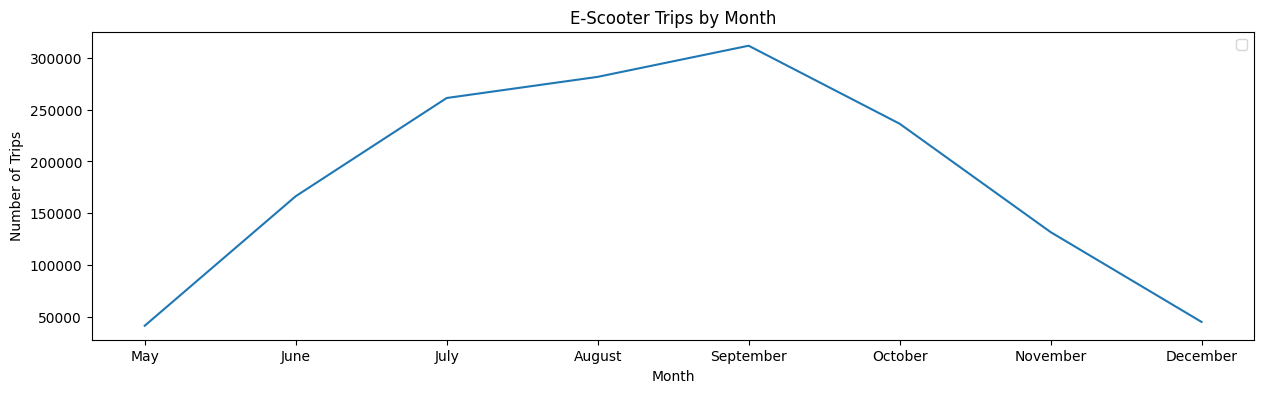

In [50]:
#Creating plot of number of trips by month
fig, ax = plt.subplots(figsize=(15,4))
trips(es_data_clean).rename({5: "May", 6 : "June", 7 : "July", 8 : "August", 9 : "September", 10 : "October", 11: "November", 12 : "December"}).plot.line("Month", ax=ax)
ax.set_title("E-Scooter Trips by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Trips")
plt.legend()
fig.show()

   Overall, number of trips saw an increase from May to Septemeber, then a decrease from September to December. In May, around around 25,000 trips were recorded with an increase of 900% by July. A slower rise from July to September is seen with a peak of highest number of rides in September of about 300,000 unique trips. The sharper increase from May to July makes sense as these mark the beginning months of summer - school is out, temperatures are slowly rising, and the tourist population in Chicago is increasing.
   We begin to see a decrease in trips per month after September, dropping to about 25,000 trips in December. This drop beginning in September may be linked to the academic year starting, major summer activities in Chicago wrapping up, and temperatures increasing. We would expect December, one of the coldest months in Chicago, to have noticibly fewer trips than May, but this may be due to missing 9 days of data in May.

Let's look at trips by throughout the day.

In [51]:
#Creating new dataframe grouped by Hour
es_data_clean['Hour'] = es_data_clean['Hour'].replace(0.0,24.0)
hourly_trips = es_data_clean.groupby(["Hour"]).size()

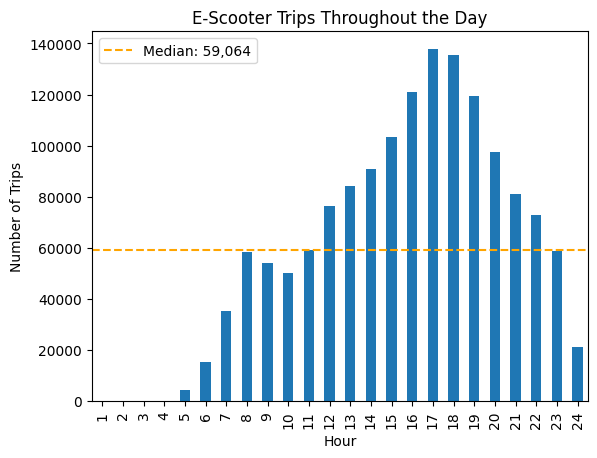

In [52]:
#Plotting new dataframe
fig, ax = plt.subplots()
hourly_trips.plot.bar()
ax.set_title("E-Scooter Trips Throughout the Day")
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Trips")
plt.axhline(y=hourly_trips.median(),color='orange', linestyle='--', label = "Median: 59,064")
plt.legend()
fig.show()

Overall, it looks like the most popular times to start a scooter ride on a given day are about 5 and 6 pm at about 140,000 rides per hour. We see the earliest rides start at 5 am (renting hours run from 5 am to 12 am) increasing until about 8 am then decreasing for a bit from 8 to 10 am. We then an increase again until 5 to 6 pm. Number of rides steadily decline again until about 12 am.

Let's look at how trips vary throughout the week.

In [53]:
#Grouping dataframe by Weekday
weekday_trips= es_data_clean.groupby(["Weekday"]).size()

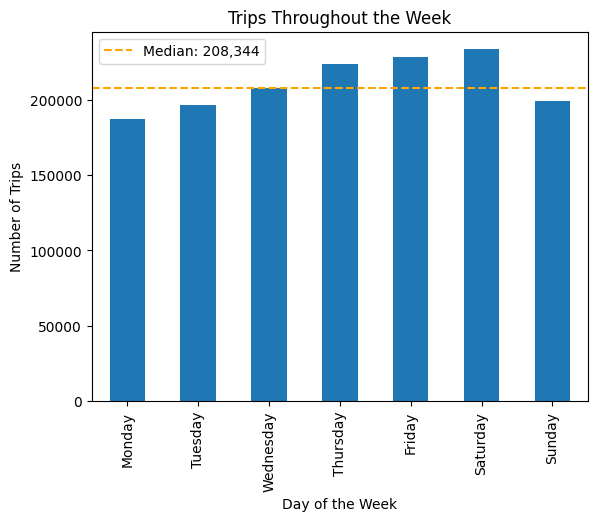

In [54]:
#Plotting weekday_trips
fig, ax = plt.subplots()
weekday_trips.rename({1: "Monday", 2 : "Tuesday", 3 : "Wednesday", 4 : "Thursday", 5 : "Friday", 6 : "Saturday", 7: "Sunday"}).plot.bar()
ax.set_title("Trips Throughout the Week")
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Number of Trips")
plt.axhline(y=weekday_trips.median(),color='orange', linestyle='--', label = "Median: 208,344")
plt.legend()
fig.show()

In terms of day of the week, we see a median of 208,344 trips throughout the week. Monday through Wednesday fall below or at this median, where as we see an increase in trips from Thursday to Saturday. Not surprisingly, Saturday is the most popular day as more people have more time throughout the day without job and school responsabilites.
Sunday and Monday are the least popular days, with trips averaging about 180,000 per day.

Let's see how number of trips throughout the day vary throughout day of the day

In [55]:
#Grouping data by Weekday and Hour
weekday_hour = es_data_clean.groupby(["Weekday", "Hour"]).size().reset_index()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


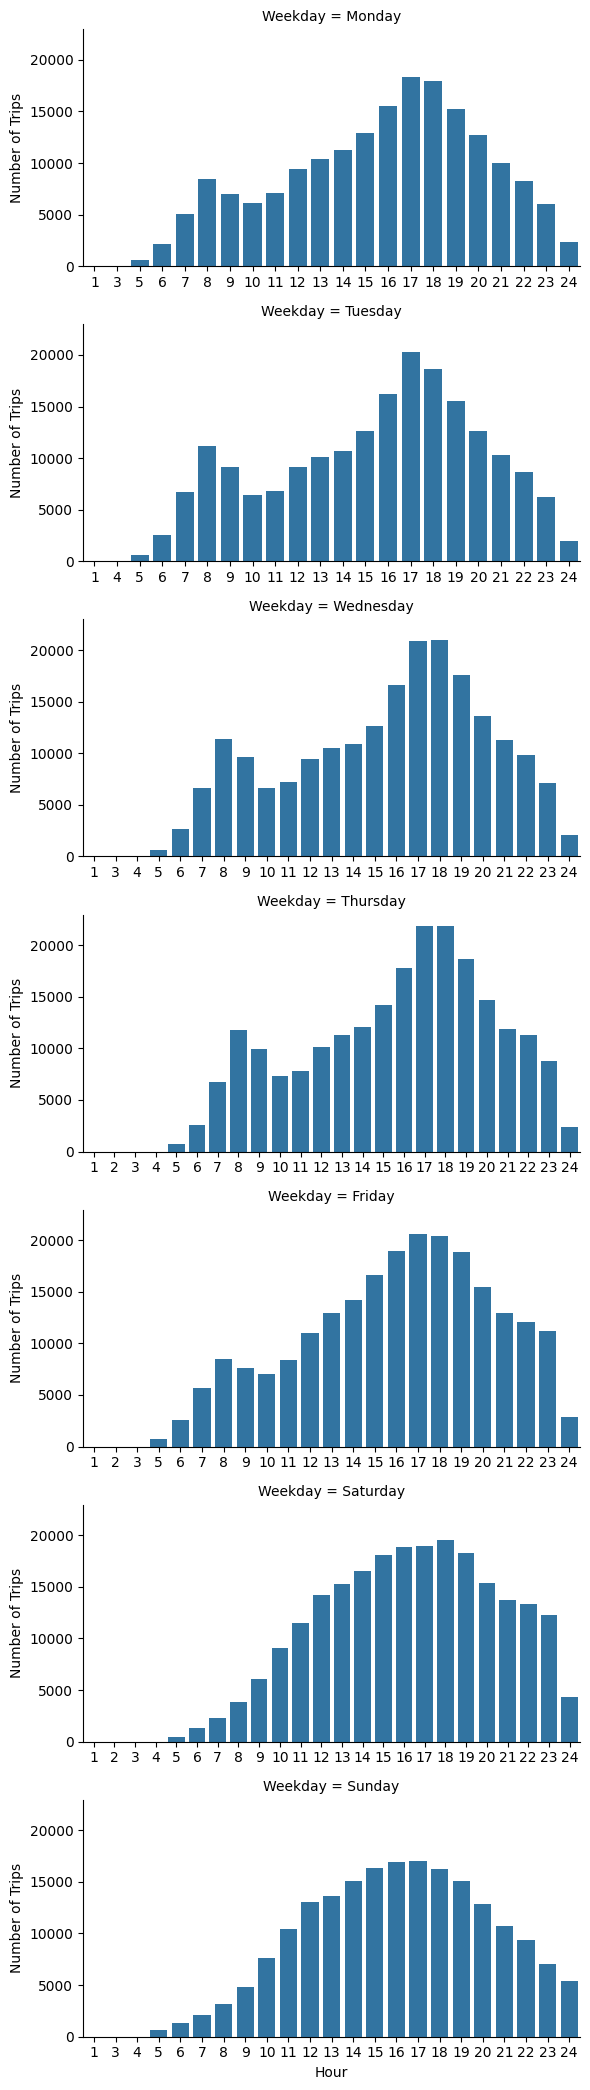

In [56]:
#PLotting weekday_hour
weekday_hour['Number of Trips'] = weekday_hour[0]
weekday_hour["Weekday"] = weekday_hour["Weekday"].replace({1: "Monday", 2 : "Tuesday", 3 : "Wednesday", 4 : "Thursday", 5 : "Friday", 6 : "Saturday", 7: "Sunday"})
g = sns.FacetGrid(weekday_hour, row = "Weekday", height = 3, aspect = 2, sharex = False)
g.map(sns.barplot, "Hour", "Number of Trips")

Monday through Friday we see similar patterns to the overall scooter rides by hour trend. On Saturdays and Sundays, we miss the work week dip from 8 - 10 am, and instead see a consistent increase in number of rides from 5 am to about 5 and 6 pm. 

Let's explore trips by vendor.

In [57]:
#Creating a dataframe grouped by Vendors
vendors = es_data_clean.groupby(["Vendor"]).size().sort_values(ascending=False)

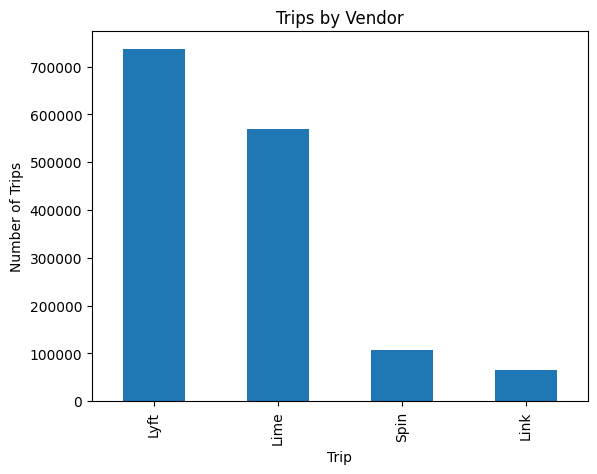

In [58]:
#Plotting dataframe

fig, ax = plt.subplots()
vendors.plot.bar()
ax.set_title("Trips by Vendor")
ax.set_xlabel("Trip")
ax.set_ylabel("Number of Trips")
fig.show()

In [59]:
#creating new dataframe grouped by Month and Vendor
trips_vendor = es_data_clean.groupby(['Month', 'Vendor']).size().reset_index()

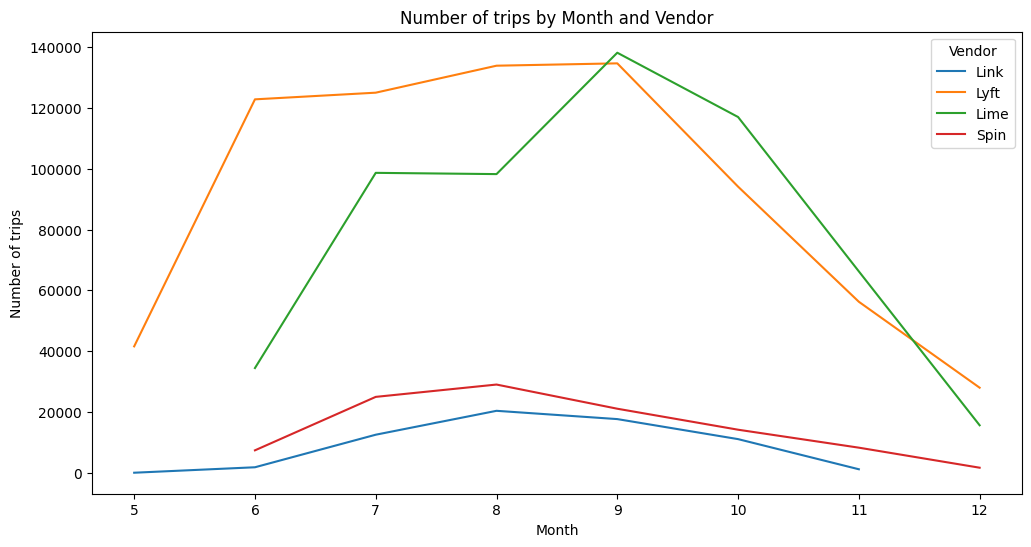

In [60]:
#Plotting dataframe 
plt.figure(figsize=(12, 6))

chart = sns.lineplot(x='Month', y = 0, hue='Vendor', data = trips_vendor)

plt.title('Number of trips by Month and Vendor')
plt.xlabel('Month')
plt.ylabel('Number of trips')

plt.show()

Lyft started as by far the most popular vendor with 40000 rides in May, whereas Link started and ended as the least popular with 0 rides in May and around 0 in Novemeber.

Overall, all 4 vendors follow similar trends but we see a dip in Lime riders in July then a sharp rise in Lime riders in August while other vendors either remained stable or decreased in riders this month. Perhaps Lime offered a promotion or special starting this month. The year ended with Lyft and Lime as direct competitors.

Let's look at most popular and least popular start areas by number of rides.

In [61]:
#Creating new dataframe of top 5 most popular Start Community Areas.
neighborhoods = es_data_clean.groupby(["Start Community Area Name"]).size().sort_values(ascending=False).head(5)

In [62]:
#Creating new dataframe of bottom 5 most popular Start Community Areas.
neighborhoods_tail = es_data_clean.groupby(["Start Community Area Name"]).size().sort_values(ascending = False).tail(5)

In [63]:
#Creating calculation to label bar chart
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

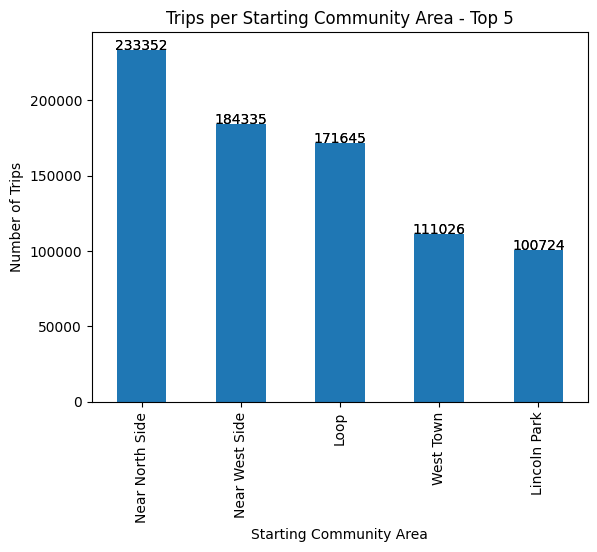

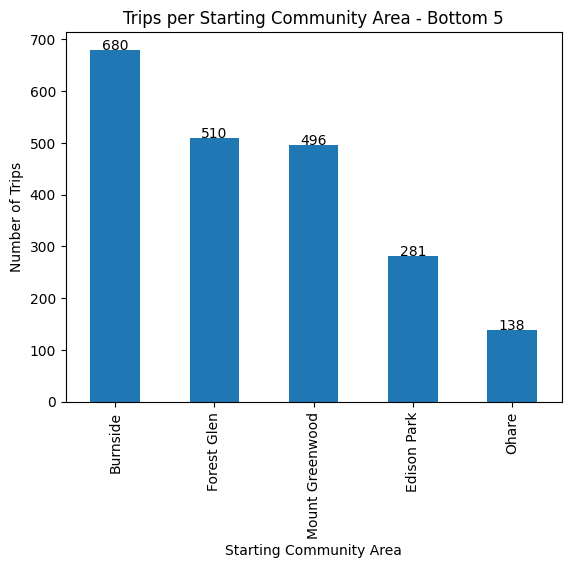

In [64]:
#PLotting bar charts
fig, ax = plt.subplots()
neighborhoods.plot.bar()
ax.set_title("Trips per Starting Community Area - Top 5")
ax.set_xlabel("Starting Community Area")
ax.set_ylabel("Number of Trips")
addlabels(neighborhoods.index, neighborhoods)
fig.show()
addlabels(neighborhoods.index, neighborhoods)

fig, ax = plt.subplots()
neighborhoods_tail.plot.bar()
ax.set_title("Trips per Starting Community Area - Bottom 5")
ax.set_xlabel("Starting Community Area")
ax.set_ylabel("Number of Trips")
addlabels(neighborhoods_tail.index, neighborhoods_tail)
fig.show()



In [65]:
#Finding percentage of top area
(es_data_clean[es_data_clean["Start Community Area Name"] == "Near North Side"].shape[0]/es_data_clean.shape[0])*100

15.81028096461197

In [66]:
#Finding area of bottom area
(es_data_clean[es_data_clean["Start Community Area Name"] == "Ohare"].shape[0]/es_data_clean.shape[0])*100

0.009349903892473395

Near North Side is by far the most popular neighborhood to start a scooter trip in 2022 with almost 250,000 recorded trips. This is about 16% of all recorded trips in 2022. The second most popular neighborhood to start a scooter trip is the Near West Side with about 185,000 trips.
O'hare experienced the least amount of scooter trips started in 2022 with about 150 recorded trips overall in 2022. Ohare trips account for less than .001% trips in 2022.

Let's look at most popular and least popular destinations.

In [67]:
#Creating new dataframe of top 5 most popular End Community Areas.
neighborhoods2 = es_data_clean.groupby(["End Community Area Name"]).size().sort_values(ascending=False).head(5)

In [68]:
#Creating new dataframe of bottom 5 most popular End Community Areas.
neighborhoods_tail2 = es_data_clean.groupby(["End Community Area Name"]).size().sort_values(ascending = False).tail(5)

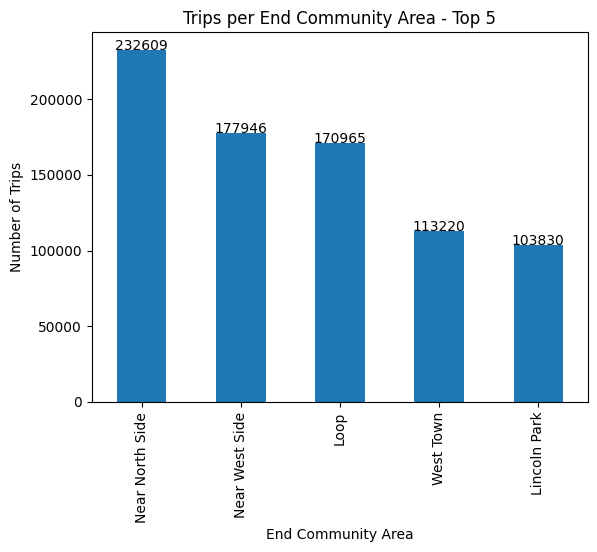

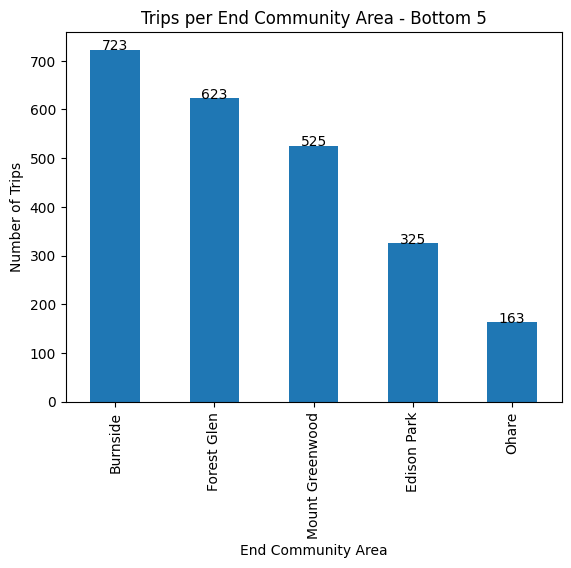

In [69]:
fig, ax = plt.subplots()
neighborhoods2.plot.bar()
ax.set_title("Trips per End Community Area - Top 5")
ax.set_xlabel("End Community Area")
ax.set_ylabel("Number of Trips")
addlabels(neighborhoods2.index, neighborhoods2)
fig.show()

fig, ax = plt.subplots()
neighborhoods_tail2.plot.bar()
ax.set_title("Trips per End Community Area - Bottom 5")
ax.set_xlabel("End Community Area")
ax.set_ylabel("Number of Trips")
addlabels(neighborhoods_tail2.index, neighborhoods_tail2)
fig.show()

There appears to be overlap between popular and least popular Start and End Community Areas which may indicate that scooters tend to be used more locally and for leisure rather than commuting. We can look at this a little more closely by creating a new boolean type column to see whether or not Start Area is the same as End Area.

In [70]:
#Creating new column to see if End Area matches Start Area
es_data_clean["StartandEnd"] = es_data_clean["Start Community Area Name"] == es_data_clean["End Community Area Name"]

In [71]:
#Finding percentage of areas with Start Area equals End Area
es_data_clean["StartandEnd"].value_counts()/es_data_clean["StartandEnd"].shape[0]*100

StartandEnd
True    58.056534
False   41.943466
Name: count, dtype: float64

This information, paired with the median values of Trip Distance Miles and Trip Duration Seconds, helps us strengthen our guess above regarding E-Scooter riders' intent to use scooters locally.

Let's look at number of rides by community area (Start Community Area Name) on a map. For reference, the top 5 and bottom 5 areas are labelled. 

In [72]:
#Grouping data by Community Area
grouped_data = es_data_clean.groupby('Start Community Area Name')['Number of Trips'].sum().reset_index()

In [73]:
merged_data = chicago_geo.merge(grouped_data, on='Start Community Area Name')

In [74]:
top_5 = merged_data.sort_values(by = "Number of Trips", ascending = False).head(5)
bottom_5 = merged_data.sort_values(by = "Number of Trips", ascending = False).tail(5)

/tmp/ipykernel_32/1460171644.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(top_5.geometry.centroid.x, top_5.geometry.centroid.y, top_5['Start Community Area Name']):
/tmp/ipykernel_32/1460171644.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(top_5.geometry.centroid.x, top_5.geometry.centroid.y, top_5['Start Community Area Name']):
/tmp/ipykernel_32/1460171644.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(bottom_5.geometry.centroid.x, bottom_5.geometry.centroid.y, bottom_5['Start Communi

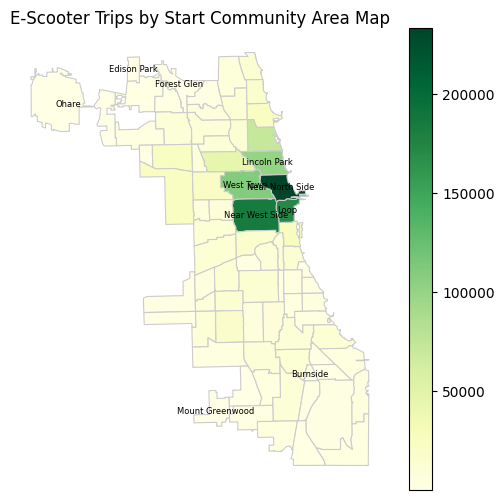

In [75]:
# Plot the choropleth map
fig, ax = plt.subplots(1, figsize=(6, 6))

for x, y, label in zip(top_5.geometry.centroid.x, top_5.geometry.centroid.y, top_5['Start Community Area Name']):
    ax.text(x, y, label, fontsize=6, ha='center', va='center', color='black')

# Add labels for the bottom 10 lowest values
for x, y, label in zip(bottom_5.geometry.centroid.x, bottom_5.geometry.centroid.y, bottom_5['Start Community Area Name']):
    ax.text(x, y, label, fontsize=6, ha='center', va='center', color='black')


# Customize the plot
merged_data.plot(column='Number of Trips', cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Customize the plot
ax.set_title('E-Scooter Trips by Start Community Area Map')
ax.set_axis_off()

# Show the map
plt.show()

In this particular map, a lighter color represents fewer number of trips whereas a darker color represents a higher number of trips. The top 5 Start Community areas - Near North Side, Near West Side, Loop, West Town, and Lincoln Park- appear to be neighboring communities all near Chicago's downtown. Perhaps the population density and number of attractions in these areas contribute to higher scooter usage. The bottom 5 Start Community areas - Burnside, Forest Glen, Mount Greenwood, Edison Park, and Ohare- are more scattered across Chicago (northwest, southwest, and south sides) - but all neighborhoods are located on the fringes/outer communities of the city.  


# Conclusion & Future Work

In summary, we notice E-Scooter usage in 2022 followed a seasonality trend. Usage increased during late spring and early summer, with a peak in usage in September, then decreased as temperatures began to drop. Lyft and Lime are by far the most popular vendors among Chicagoans and experience fluctuations in being the most used vendor. Riders used scooters for either short commutes or leisure which is evidenced by the median distance travelled of 1 mile and median duration of 9 minutes. Additionally, scooters were most used in the early evening, after work and school for most, around 4 pm to 6 pm with a stronger preference to ride on Saturdays. Over 50% of rides started and ended in the same community area with ares more centrally located, such as the Near North Side, Near West Side, Loop, West Town, and Lincoln Park, being the most popular community areas and outer communities such as Burnside, Forest Glen, Mount Greenwood, Edison Park, and Ohare, being the least popular.

Future analysis may want to compare 2022 data against the original 2019 and 2020 data to identify any changes in E-Scooter usage and determine which areas have increased and decreased usage since 2019. 

